In [1]:
#======================================
# Libraries Needed
#======================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import pandas as pd
import re

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# A. Loading the Data
The first part of this project will be to download and view some basic information pertaining to our dataset. This will allow us to have a general idea as to how to move forward with the project as well as understand how the initial data is strucutured. 

In [3]:
#Training Data
train = pd.read_csv('train.csv')
train_labels = pd.read_csv('train_labels.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head() #Test to see if you can read the data

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [5]:
train_labels.head() #Test to see if you can read the data

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      int64  
 1   index           int64  
 2   elapsed_time    int64  
 3   event_name      object 
 4   name            object 
 5   level           int64  
 6   page            float64
 7   room_coor_x     float64
 8   room_coor_y     float64
 9   screen_coor_x   float64
 10  screen_coor_y   float64
 11  hover_duration  float64
 12  text            object 
 13  fqid            object 
 14  room_fqid       object 
 15  text_fqid       object 
 16  fullscreen      int64  
 17  hq              int64  
 18  music           int64  
 19  level_group     object 
dtypes: float64(6), int64(7), object(7)
memory usage: 3.9+ GB


#### Summary of Initial Finding
Even though we have just loaded the data, there are several key features that can be idenitified. These will need to be addressed moving forward and will be vital to the creation of model:
1. As shown by the `train.info()` the dataset that we are using is massive:
    * Before we begin dealing with any type of feature analysis we must reduce the amount of memory used up by our system. 
    * The result of this is to improve the performance of the runtime of our model <br><br>
2. The dataset, while large, consisits of several observations pertaining to the same `session_id`. 
    * This implies that we will need to perform some aggreagation prior to any modeling. 

# B. Reducing Memory Usage of the Dataset
Having now downloaded data, we will make it more manegagble to use by reducing the memory required to process it.

In [7]:
# Function to reduce memory
def reduce_memory(df):   
    for col in df.columns:
        col_type = df[col].dtype.name
        
        #Only focuses on numerical data (categorical data is handled later)
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')): #DateTime object and Category object
            if (col_type != 'object'): #Object type
                col_min = df[col].min()
                col_max = df[col].max()

                #Only focuses on if the type of the attribute is of type 'int'
                # np.iinfo() finds the Machine Limits for the data type
                if str(col_type)[:3] == 'int':
                    #Case 1: If the Machine Limits of the attribute fall between those of type int8
                    if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8) #Changes the type to int8
                    #Case 2: If the Machine Limits of the attribute fall between those of type int16
                    elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16) #Changes the type to int16
                    #Case 3: If the Machine Limits of the attribute fall between those of type int32
                    elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32) #Changes the type to int32
                    #Case 4: If the Machine Limits of the attribute fall between those of type int64
                    elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64) #Changes the type to int64

                #Only focuses on if the type of the attribute is of type 'float'
                # np.finfo() finds the Machine Limits for the data type
                else:
                    #Case 1: If the Machine Limits of the attribute fall between those of type float16
                    if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    #Case 1: If the Machine Limits of the attribute fall between those of type float32
                    elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    #All other cases doesn;t change
                    else:
                        pass
            
            #If the attribute is an object than it will change its type to category
            else:
                df[col] = df[col].astype('category')
    
    return df

In [8]:
#produce a copy of the dataset, but now using reduced memory. 
train_df = reduce_memory(train)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      int64   
 1   index           int16   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           int8    
 6   page            float16 
 7   room_coor_x     float16 
 8   room_coor_y     float16 
 9   screen_coor_x   float16 
 10  screen_coor_y   float16 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      int8    
 17  hq              int8    
 18  music           int8    
 19  level_group     category
dtypes: category(7), float16(5), float32(1), int16(1), int32(1), int64(1), int8(4)
memory usage: 1.0 GB


As the above illustrates, we have reduced the amount of memory used from `3.9+ GB` to `1.0 GB`. This is about a 75% decrease! We also will reduce the memory usage of the labels (as shown below).  

In [9]:
#produces a copy of the labels, but now using reduced memory. 
labels_df = reduce_memory(train_labels)
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424116 entries, 0 to 424115
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   session_id  424116 non-null  category
 1   correct     424116 non-null  int8    
dtypes: category(1), int8(1)
memory usage: 21.4 MB


In [10]:
labels_df['user_id']=labels_df.session_id.str.split("_", expand = True)[0]

In [11]:
del(train) #saves memory

# C. Understanding the Game/Preprocessing New Dataframe
Before we begin preprocessing the data, it is important to explain the overall structure of the game. Doing so will explain some of the future changes that will be performed on our dataset for the sake of improving our models.

## I. Structure of the Game
Regardless of who is playing, each game lasts five chapters. The player must navigate the map and interact with the environment to collect clues to complete their objective. Once completed, the player will be assessed on the conclusions made based on the clues collected.

## II. Structure of Events
Each game consists of a series of events of in the `event_name` attribute. These consist of the following:

In [12]:
#Number of events in the games 
for i in train_df['event_name'].unique():
    print(i)

cutscene_click
person_click
navigate_click
observation_click
notification_click
object_click
object_hover
map_hover
map_click
checkpoint
notebook_click


Out of all of the events shown, the most important of them are the `checkpoint` event:

In [107]:
train_df[train_df['event_name'] == 'checkpoint'].head(6)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
164,20090312431273200,164,194860,checkpoint,basic,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,1,0-4
460,20090312431273200,470,499235,checkpoint,basic,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,1,5-12
880,20090312431273200,931,1272679,checkpoint,basic,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22
1019,20090312433251036,138,233752,checkpoint,basic,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,0,0-4
1414,20090312433251036,544,817609,checkpoint,basic,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,0,5-12
2711,20090312433251036,1875,3815334,checkpoint,basic,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,0,13-22


As the above illustrates, there are 3 checkpoint events per session; representing the three separate quizzes given. It is important to realize that **almost all the information (_excluding `elasped time`_) pertaining to these rows are intentionally removed**; as they contain specific texts and flags indicating whether the player correctly answered the question.

Because the only attribute given is the `elapsed_time` that passed, it is most likely the most important feature in determining whether a player correctly answered the question (as the longer the event would take, the move likely the player took multiple attempts to pick the correct response). Consequently, we will create a separate dataframe only containing 3 numerical features: `elasped_time`, `quiz_time`, and `section_time`:
* The `quiz_time` is calcualted by subtracting when the quiz was recorded to the previous event. The idea is the longer a player took in taking the quiz the more likely that they needed multiple attempts to select the right responses.
* The `section_time` is calculated by subtracting the `elapsed_time` occurring between each quiz (excluding the first quiz as that is already calculated correctly. The idea is the longer it took a students to get to the quiz portion the more likely they struggled in comprehending the objectives and finding the clues needed to correctly answer the questions. 

We will perform some inital neural network on this simplified dataset before we incorporate the original.

In [108]:
#========================================================================================
# Creation of quiz_time column
#========================================================================================

#Dataframe containing only the elasped_time and the quiz_time for the checkpoint event
checkpoint_index = list(train_df[train_df['event_name'] == 'checkpoint'].index.values)

new_chp_index = list(train_df[train_df['event_name'] == 'checkpoint'].index.values + 1)
new_chp_index.remove(new_chp_index[-1])

#train_df.iloc[checkpoint_index]

In [109]:
joined_indx = checkpoint_index + new_chp_index #index containing checkpoint event and new chapter

In [110]:
#check
print(checkpoint_index[-1])
print(new_chp_index[-1])

26296945
26296186


In [111]:
#check to see if indicies were joined correctly
print(len(checkpoint_index))
print(len(new_chp_index))
print(len(joined_indx))

71028
71027
142055


In [112]:
#Sort the indexes into their correct placement
joined_indx.sort()

In [113]:
#Creates dataframe only containing information pertaining to the checkpoint of the data
checkpoint_df = train_df.iloc[joined_indx]
#checkpoint_df.head(6)
print(len(checkpoint_df))

142055


In [114]:
#Creates the quiz_time attribute
checkpoint_df['quiz_time'] = checkpoint_df['elapsed_time'].shift(-1).fillna(5487952.0)-checkpoint_df['elapsed_time']

checkpoint_df.head(6) #test

C:\Users\Joshn\AppData\Local\Temp\ipykernel_30020\2166639167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkpoint_df['quiz_time'] = checkpoint_df['elapsed_time'].shift(-1).fillna(5487952.0)-checkpoint_df['elapsed_time']


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,quiz_time
164,20090312431273200,164,194860,checkpoint,basic,4,NaN,NaN,NaN,NaN,...,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,1,0-4,26625.0
165,20090312431273200,175,221485,navigate_click,undefined,5,NaN,280.50,-19.703125,653.0,...,NaN,NaN,boss,tunic.capitol_0.hall,NaN,0,0,1,5-12,277750.0
460,20090312431273200,470,499235,checkpoint,basic,12,NaN,NaN,NaN,NaN,...,NaN,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,1,5-12,337497.0
461,20090312431273200,512,836732,navigate_click,undefined,13,NaN,290.25,-204.500000,651.0,...,NaN,NaN,NaN,tunic.capitol_1.hall,NaN,0,0,1,13-22,435947.0
880,20090312431273200,931,1272679,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22,-1272679.0
881,20090312433251036,0,0,cutscene_click,basic,0,NaN,-395.00,84.687500,399.0,...,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,0,0-4,233752.0


Looking at the `quiz_time` attribute, there are several negative elements that periodically occur. Unfortunately, we will never know approximately how long it took to answer quiz 3 as the game would be over and the time resets (that explains why we have those negative values). To rectify the issue for our model, we will replace all negative values in the attribute by an estimate of the time that it took. Our estimation will be based on the following formula:

$$ \frac{AverageTime}{13} \times 5 $$

where:
* `TotalTime`: is the total time of both Quiz 1 and 2
* `13` are the number of questions asked in total for Quizzes 1 and 2
* `5` are the number of questions asked for Quiz 3

In [115]:
checkpoint_df = checkpoint_df[checkpoint_df['event_name'] == 'checkpoint']
checkpoint_df.head(6) #check

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,quiz_time
164,20090312431273200,164,194860,checkpoint,basic,4,NaN,NaN,NaN,NaN,...,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,1,0-4,26625.0
460,20090312431273200,470,499235,checkpoint,basic,12,NaN,NaN,NaN,NaN,...,NaN,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,1,5-12,337497.0
880,20090312431273200,931,1272679,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22,-1272679.0
1019,20090312433251036,138,233752,checkpoint,basic,4,NaN,NaN,NaN,NaN,...,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,0,0-4,33131.0
1414,20090312433251036,544,817609,checkpoint,basic,12,NaN,NaN,NaN,NaN,...,NaN,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,0,5-12,358874.0
2711,20090312433251036,1875,3815334,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,0,13-22,-3815334.0


In [125]:
#converts list to values
val = checkpoint_df['quiz_time'].values
len(val)

71030

In [145]:
#changes the values of quiz_time so all the negative elements are replaced with the estimated average
quiz_time = []
for i in range(len(val)):
    if val[i] >= 0:
        quiz_time.append(val[i])
    else:
        estimate = abs(val[i-2] + val[i-1]) / 13 * 5
        quiz_time.append(estimate)

In [147]:
len(quiz_time) #check

71030

In [149]:
#Incorpates changes to quiz_time column
checkpoint_df['quiz_time'] = quiz_time
checkpoint_df.head(6)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,quiz_time
164,20090312431273200,164,194860,checkpoint,basic,4,NaN,NaN,NaN,NaN,...,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,1,0-4,26625.000000
460,20090312431273200,470,499235,checkpoint,basic,12,NaN,NaN,NaN,NaN,...,NaN,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,1,5-12,337497.000000
880,20090312431273200,931,1272679,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22,140046.923077
1019,20090312433251036,138,233752,checkpoint,basic,4,NaN,NaN,NaN,NaN,...,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,0,0-4,33131.000000
1414,20090312433251036,544,817609,checkpoint,basic,12,NaN,NaN,NaN,NaN,...,NaN,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,0,5-12,358874.000000
2711,20090312433251036,1875,3815334,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,0,13-22,150771.153846


In [185]:
#================================================================
# Creation of section_time column
#================================================================
section_time = []
val = checkpoint_df['elapsed_time'].values

In [186]:
#Creates array containing the time for each section
for i in range(len(val)):
    if i == 0: #First element doesn't need to be changed
        section_time.append(val[i])
    elif i % 3 == 0: #Every 4th element does not need to be changed
        section_time.append(val[i])
    else:
        section_time.append(abs(val[i] - val[i-1])) #Takes the difference to find the time in between

In [187]:
section_time[0:10] #check

[194860,
 304375,
 773444,
 233752,
 583857,
 2997725,
 363226,
 269634,
 556190,
 192793]

In [188]:
#Creates section time
checkpoint_df['section_time'] = section_time
checkpoint_df.head(6)

,session_id,index,elapsed_time,level,fullscreen,hq,music,level_group,quiz_time,section_time
164,20090312431273200,164,194860,4,0,0,1,0-4,26625.000000,194860
460,20090312431273200,470,499235,12,0,0,1,5-12,337497.000000,304375
880,20090312431273200,931,1272679,22,0,0,1,13-22,140046.923077,773444
1019,20090312433251036,138,233752,4,0,0,0,0-4,33131.000000,233752
1414,20090312433251036,544,817609,12,0,0,0,5-12,358874.000000,583857
2711,20090312433251036,1875,3815334,22,0,0,0,13-22,150771.153846,2997725


## III. Removing columns that are all NaN
Having now creating a dataframe consisting of only the `checkpoint_events` with newly created attributes. We will remove all empty columns as they are uneeded. We will use this dataframe for initial testing. We also will remove all columns that contain the same value (such as `event_name`) as they will contribute nothing to the performance of our model. 

In [180]:
attrs= ['event_name', 'name', 'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'text', 'fqid',
        'room_fqid', 'text_fqid', 'hover_duration' ]

checkpoint_df = checkpoint_df.drop(columns = attrs, axis = 1)

In [181]:
checkpoint_df.head()

,session_id,index,elapsed_time,level,fullscreen,hq,music,level_group,quiz_time,section_time
164,20090312431273200,164,194860,4,0,0,1,0-4,26625.000000,194860
460,20090312431273200,470,499235,12,0,0,1,5-12,337497.000000,304375
880,20090312431273200,931,1272679,22,0,0,1,13-22,140046.923077,773444
1019,20090312433251036,138,233752,4,0,0,0,0-4,33131.000000,233752
1414,20090312433251036,544,817609,12,0,0,0,5-12,358874.000000,583857


# D. Preprocessing the Dataset
Having reduced the memory required to download the data and after creating an initial dataset to work with, we will now prepocess the data in preparation for the model.

In [182]:
# Creating a summary of the dataset
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['data type'])
    summary_df['#missing'] = df.isnull().sum().values * 100      #Calculates the number of missing values
    summary_df['#unique'] = df.nunique().values                  #Caluclates the number of unique values   
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summary_df['min'] = desc['min'].values                       #For numerical data, calculates the min value
    summary_df['max'] = desc['max'].values                       #For numerical data, calulcates the max value
    
    return summary_df #displays summary dataframe

In [189]:
#summary for newly created checkpoint df
checkpoint_summary = summary(checkpoint_df)
checkpoint_summary

,data type,#missing,#unique,min,max
session_id,int64,0,23562,20090312431273200.0,22100221145014656.0
index,int16,0,2435,0.0,20473.0
elapsed_time,int32,0,69855,300.0,1987182816.0
level,int8,0,3,4.0,22.0
fullscreen,int8,0,2,0.0,1.0
hq,int8,0,2,0.0,1.0
music,int8,0,2,0.0,1.0
level_group,category,0,3,NaN,NaN
quiz_time,float64,0,64737,0.0,1743228199.0
section_time,int64,0,69996,0.0,1987024578.0


In [184]:
#summary for the original dataframe
summary_table = summary(train_df)
summary_table

,data type,#missing,#unique,min,max
session_id,int64,0,23562,20090312431273200.0,22100221145014656.0
index,int16,0,20348,0.0,20473.0
elapsed_time,int32,0,5042639,0.0,1988606704.0
event_name,category,0,11,NaN,NaN
name,category,0,6,NaN,NaN
level,int8,0,23,0.0,22.0
page,float16,2573240200,7,0.0,6.0
room_coor_x,float16,207327200,29854,-1992.0,1262.0
room_coor_y,float16,207327200,27847,-918.0,543.5
screen_coor_x,float16,207327200,6866,0.0,1919.0


Using the summary table above, we were able to decide on perform the following tasks to modify our original dataset:
1. We can one-hot encode the attributes `event_name`, `name`, and `room_fqid` to change the categorical data into numerical ones 

2. Although the attributes `fullscreen`, `hq`, and `music` contain numerical elements, they are categorical attributes in disguise. Therefore, we will also one-hot encode these attributes aswell. 

3. The numerical attributes `elasped_time` and `hover_duration` appear to have outliers (based on the range between min and max values). Therefore, we deal with this discrepency by removing outliers

4. We must deal with all attributes pertaining to anything `text` related and try to chiphen (if possible) any numerical information out of them.


4. Dependent on the structrue of our game, we may be able to create new attributes prior to the creation of our model. 

## a. One-Hot Encoding Categorical Variables
The following converts all of the categorical variables listed above (excluding `text` columns) into numerical ones:

In [14]:
#========================================================================
# One-Hot Encoding Categorical Variables
#========================================================================

cat_att = ['event_name', 'name', 'room_fqid', 'fullscreen', 'hq', 'music'] #categorical attributes (from above)

for column in cat_att:
    temp_df = pd.get_dummies(train_df[column], prefix=column)
    
    train_df = pd.merge(
        left = train_df,
        right = temp_df,
        left_index = True,
        right_index = True,
    )
    
train_df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,room_fqid_tunic.kohlcenter.halloffame,room_fqid_tunic.library.frontdesk,room_fqid_tunic.library.microfiche,room_fqid_tunic.wildlife.center,fullscreen_0,fullscreen_1,hq_0,hq_1,music_0,music_1
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,1,0,1,0,0,1
1,20090312431273200,1,1323,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,1,0,1,0,0,1
2,20090312431273200,2,831,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,1,0,1,0,0,1
3,20090312431273200,3,1147,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,1,0,1,0,0,1
4,20090312431273200,4,1863,person_click,basic,0,NaN,-413.0,-159.375,381.0,...,0,0,0,0,1,0,1,0,0,1


In [15]:
# Getting shape of the df
shape = train_df.shape
  
# Printing Number of columns
print('Number of columns :', shape[1])

Number of columns : 62


In [16]:
#dropping the unnessary attributes
train_df = train_df.drop(columns = ['room_fqid', 'fullscreen', 'hq', 'music'], axis = 1)

Notice, we are **not** dropping the `event_name` and `name` attributes even though these attributes were also categorical. That is becuase these attributes will be important in the creation of new features later on. 

In [17]:
# Getting shape of the df
shape = train_df.shape
  
# Printing Number of columns
print('Number of columns :', shape[1])

Number of columns : 58


## b. Creating New Attribute Called _Event Time_
The original dataset contains the feature `elasped_time` which measures _how much time has passed (in milliseconds) between the start of the session and when the event was recorded_. Using this feature, we can caluclate the total time each individual event took by subtracting the following time in the column with the current elasped time.

It is important to note that for the `elasped_time` feature, some of the time meaurements do not consecutive increases. In fact, some decrease as shown below. 

In [18]:
train_df['elapsed_time'].head(3)

0       0
1    1323
2     831
Name: elapsed_time, dtype: int32

This is most likely an error with how the game tracked the time. As a result, to mitigate some of the issue we must take the absolute value of that difference (as shown below):

In [19]:
train_df['event_time'] = abs(train_df['elapsed_time'].shift(-1).fillna(5487952.0)-train_df['elapsed_time'])
train_df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,room_fqid_tunic.library.frontdesk,room_fqid_tunic.library.microfiche,room_fqid_tunic.wildlife.center,fullscreen_0,fullscreen_1,hq_0,hq_1,music_0,music_1,event_time
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,1,0,1,0,0,1,1323.0
1,20090312431273200,1,1323,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,1,0,1,0,0,1,492.0
2,20090312431273200,2,831,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,1,0,1,0,0,1,316.0
3,20090312431273200,3,1147,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,1,0,1,0,0,1,716.0
4,20090312431273200,4,1863,person_click,basic,0,NaN,-413.0,-159.375,381.0,...,0,0,0,1,0,1,0,0,1,1560.0


### Understanding the Structure of the Jo Wilder Game
In short, the game consists of five chapters. Within the chapters of the game the player must traverse both the map and interact with the environment to idenitfy clues which are then written down in a notebook. Having found all the necessary clues to complete the objectve for a chapter, the player will then navigate to the Capital Buidung where they will be questioned on the information gathered and the conclusion that they come up with. For each question asked, the boss of the game will either provide a phrase of text wither confirming the player correctly got a question right, or telling the player to try again. Once all questions are answers the next section begins. 

What makes the above so interesting is how the dataset is structured. 

In short, the game can be broken down into the following key events:

**Chapter 1**

0. Startgame
1. Find Notebook
2. Wiscwonders
3. Mysteryslip
4. Quiz Checkpoint #1

**Chapter 2**

5. notajersey
6. trashed
7. archivist
8. textile
9. logbook
10. suffragist
11. taxidermist
12. Quiz Checkpoint #2


What

Having changed some initial categorical attributes into numerical ones, we will address the outliers.

### b. Handling Outliers (Winzorization Method)
To handle the following outliers, we will cap the data values that pertain to the numerical attributes. By capping the data values, we maintain the same number of observations while still dealing with outliers. Our caps will be at the 5th percentile and 95th percentile. 

In [18]:
#===================================================================
# Confirming Outliers
#===================================================================

num_attr = ['elapsed_time', 'hover_duration'] #numerical attributes listed above

def CountOutliers(attributes):
    num_outliers = 0
    
    for col in attributes:
        #Finds some Summary Statistics
        Q1 = train_df[col].quantile(0.25)
        Q3 = train_df[col].quantile(0.75)
        IQR = Q3 - Q1
    
        num_outliers = ((train_df[col]<(Q1-1.5*IQR)) | (train_df[col]>(Q3+1.5*IQR))).sum()
    
        print("There are "+ str(num_outliers) + " outliers in the " + col + " column.")
        
CountOutliers(num_attr) #Test

#Sets up a zoomed in version of the boxplot
# plt.rcParams["figure.figsize"] = [16.0, 4.0] #sets the graph sizes
# plt.xlim(0,4000000) #Displays a zoomed in version of the boxplot
# train_df.boxplot(column= 'elapsed_time', return_type='axes',vert = False) #elasped Time

There are 1905440 outliers in the elapsed_time column.
There are 282683 outliers in the hover_duration column.


In [56]:
from scipy.stats.mstats import winsorize #library neeeded
#========================================================================================
# Removing Outliers
#========================================================================================

# Winzorization Method resticts the data of elasped_time column up to the 90% percentile
train_df['elapsed_time_winsr'] = winsorize(train_df['elapsed_time'], limits=[None, 0.09]) #elasped time

# Winzorization Method resticts the data of elasped_time column up to the 85% percentile
mask = ~train_df['hover_duration'].isna() #displays which elements are NaN in the hover_duration column
train_df.loc[mask, 'hover_duration_winsr'] = winsorize(train_df['hover_duration'].loc[mask], limits=[None, 0.15])

In [57]:
num_attr = ['elapsed_time_winsr', 'hover_duration_winsr']
CountOutliers(num_attr) #Test

There are 0 outliers in the elapsed_time_winsr column.
There are 0 outliers in the hover_duration_winsr column.


<AxesSubplot:>

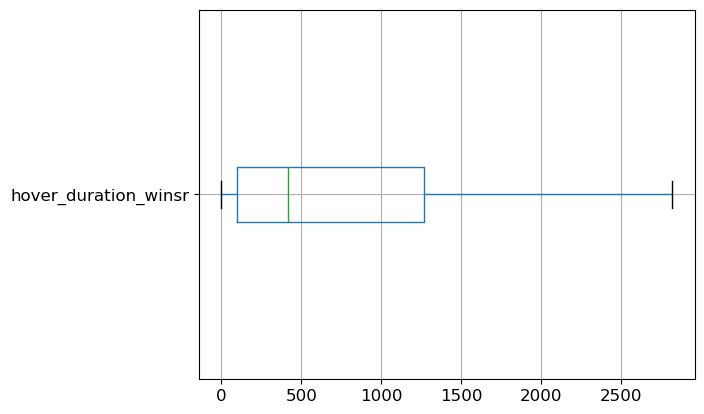

In [58]:
train_df.boxplot(column= 'hover_duration_winsr', return_type='axes', vert = False)

<AxesSubplot:>

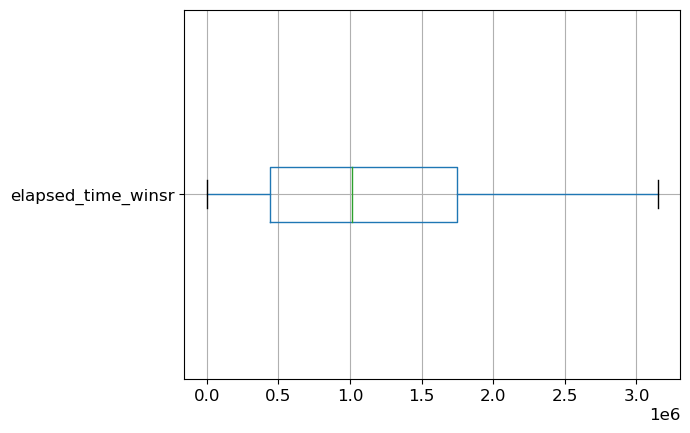

In [60]:
train_df.boxplot(column= 'elapsed_time_winsr', return_type='axes', vert = False)

In [61]:
#Drops the unnecessary columns
train_df = train_df.drop(columns = ['elapsed_time', 'hover_duration'], axis = 1)

In [62]:
train_df.head()

,session_id,index,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,text,fqid,...,room_fqid_tunic.library.microfiche,room_fqid_tunic.wildlife.center,fullscreen_0,fullscreen_1,hq_0,hq_1,music_0,music_1,elapsed_time_winsr,hover_duration_winsr
0,20090312431273200,0,0,NaN,-414.0,-159.375,380.0,494.0,undefined,intro,...,0,0,1,0,1,0,0,1,0,NaN
1,20090312431273200,1,0,NaN,-414.0,-159.375,380.0,494.0,"Whatcha doing over there, Jo?",gramps,...,0,0,1,0,1,0,0,1,1323,NaN
2,20090312431273200,2,0,NaN,-414.0,-159.375,380.0,494.0,Just talking to Teddy.,gramps,...,0,0,1,0,1,0,0,1,831,NaN
3,20090312431273200,3,0,NaN,-414.0,-159.375,380.0,494.0,I gotta run to my meeting!,gramps,...,0,0,1,0,1,0,0,1,1147,NaN
4,20090312431273200,4,0,NaN,-413.0,-159.375,381.0,494.0,"Can I come, Gramps?",gramps,...,0,0,1,0,1,0,0,1,1863,NaN


### c. Modifying the Text Data
As `train_df` shows, there is an attribute called `text`. We believe that the text that is played at each observation (if applicable) is important. We assume that particular responses are choosen depending on whether or not the player was able to correctly answer the question. Therefore, prior to any model selection, we must first perform some text mining and language processing. 

# STILL NEED TO FINISH THIS SECTION THEN OFF TO FEATURE SELECTION WITH RANDOM FORREST

In [21]:
train_df[train_df['text_fqid'] == 'tunic.historicalsociety.collection.tunic.slip']['text']

85                   This looks like a clue!
86          I'll record this in my notebook.
956                  This looks like a clue!
957         I'll record this in my notebook.
2814                 This looks like a clue!
                          ...               
26293411    I'll record this in my notebook.
26294622             This looks like a clue!
26294623    I'll record this in my notebook.
26295499             This looks like a clue!
26295500    I'll record this in my notebook.
Name: text, Length: 47626, dtype: category
Categories (597, object): ['*COUGH COUGH COUGH*', '*cough cough*', '*grumble grumble*', 'A boring old shirt.', ..., '\u00f0\u0178\u02dc\u00b4', '\u00f0\u0178\u02dc\u0160', '\u00f0\u0178\u2122\u201e', 'undefined']

In [34]:
train_df[train_df.index == 90]

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,room_fqid_tunic.library.frontdesk,room_fqid_tunic.library.microfiche,room_fqid_tunic.wildlife.center,fullscreen_0,fullscreen_1,hq_0,hq_1,music_0,music_1,event_time
90,20090312431273200,90,95883,person_click,basic,2,NaN,-60.4375,-253.875,377.0,...,0,0,0,1,0,1,0,0,1,209.0


In [35]:
type(train_df['room_coor_x'])
type(train_df['elapsed'])

pandas.core.series.Series

In [32]:
type(winsorize(train_df['elapsed_time'], limits=[None, 0.05]))

numpy.ma.core.MaskedArray

In [ ]:
df2 = pd.DataFrame(d2)

In [127]:
print(train['event_name'].unique())

['cutscene_click', 'person_click', 'navigate_click', 'observation_click', 'notification_click', ..., 'object_hover', 'map_hover', 'map_click', 'checkpoint', 'notebook_click']
Length: 11
Categories (11, object): ['cutscene_click', 'person_click', 'navigate_click', 'observation_click', ..., 'map_hover', 'map_click', 'checkpoint', 'notebook_click']


In [71]:
ex = train[train['event_name'] == 'notebook_click']

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
941,20090312433251036,60,60743,notebook_click,open,2,0.0,-1112.320519,-518.582269,30.0,639.0,NaN,NaN,NaN,tunic.historicalsociety.entry,NaN,0,0,0,0-4
942,20090312433251036,61,61761,notebook_click,close,2,0.0,73.221989,428.191813,789.0,58.0,NaN,NaN,NaN,tunic.historicalsociety.entry,NaN,0,0,0,0-4
1079,20090312433251036,209,351064,notebook_click,open,6,1.0,-490.732665,-429.718879,61.0,629.0,NaN,NaN,NaN,tunic.historicalsociety.basement,NaN,0,0,0,5-12
1080,20090312433251036,210,354779,notebook_click,basic,6,1.0,-97.641756,-304.264333,343.0,539.0,NaN,NaN,NaN,tunic.historicalsociety.basement,NaN,0,0,0,5-12
1081,20090312433251036,211,357947,notebook_click,close,6,1.0,556.115820,342.523546,812.0,75.0,NaN,NaN,NaN,tunic.historicalsociety.basement,NaN,0,0,0,5-12
1283,20090312433251036,413,651200,notebook_click,open,11,3.0,-465.209958,-493.807297,48.0,628.0,NaN,NaN,NaN,tunic.historicalsociety.entry,NaN,0,0,0,5-12
1284,20090312433251036,414,654048,notebook_click,close,11,3.0,795.143497,390.394158,822.0,85.0,NaN,NaN,NaN,tunic.historicalsociety.entry,NaN,0,0,0,5-12
1407,20090312433251036,537,803374,notebook_click,open,12,3.0,-445.669594,-508.462569,60.0,637.0,NaN,NaN,NaN,tunic.historicalsociety.entry,NaN,0,0,0,5-12
1408,20090312433251036,538,808529,notebook_click,close,12,3.0,780.488224,377.367249,813.0,93.0,NaN,NaN,NaN,tunic.historicalsociety.entry,NaN,0,0,0,5-12
1474,20090312433251036,638,1239444,notebook_click,open,15,4.0,-1537.372637,-356.466977,31.0,629.0,NaN,NaN,NaN,tunic.historicalsociety.cage,NaN,0,0,0,13-22


In [89]:
train[train['event_name'] == 'cutscene_click']

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
41,20090312431273200,41,45062,cutscene_click,basic,1,NaN,93.811703,-60.345450,338.0,368.0,NaN,Let's get started. The Wisconsin Wonders exhib...,groupconvo,tunic.historicalsociety.entry,tunic.historicalsociety.entry.groupconvo,0,0,1,0-4
42,20090312431273200,42,46046,cutscene_click,basic,1,NaN,133.978871,-85.715094,390.0,386.0,NaN,Who wants to investigate the shirt artifact?,groupconvo,tunic.historicalsociety.entry,tunic.historicalsociety.entry.groupconvo,0,0,1,0-4
43,20090312431273200,43,47362,cutscene_click,basic,1,NaN,125.931445,-83.374177,390.0,385.0,NaN,Not Leopold here. He's been losing papers lately.,groupconvo,tunic.historicalsociety.entry,tunic.historicalsociety.entry.groupconvo,0,0,1,0-4
44,20090312431273200,44,48112,cutscene_click,basic,1,NaN,123.708202,-80.064777,389.0,383.0,NaN,Hey!,groupconvo,tunic.historicalsociety.entry,tunic.historicalsociety.entry.groupconvo,0,0,1,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26296473,22100221145014656,1132,4729094,cutscene_click,basic,18,NaN,382.415540,68.134243,548.0,292.0,NaN,Make sure to get some old photos for the exhib...,groupconvo_flag,tunic.historicalsociety.entry,tunic.historicalsociety.entry.groupconvo_flag,0,0,1,13-22
26296474,22100221145014656,1133,4730995,cutscene_click,basic,18,NaN,333.564631,40.452061,518.0,309.0,NaN,Wait! Can't I do it?,groupconvo_flag,tunic.historicalsociety.entry,tunic.historicalsociety.entry.groupconvo_flag,0,0,1,13-22
26296475,22100221145014656,1134,4734449,cutscene_click,basic,18,NaN,-53.985915,154.437515,280.0,239.0,NaN,The symbol on the flag looks sort of like a de...,groupconvo_flag,tunic.historicalsociety.entry,tunic.historicalsociety.entry.groupconvo_flag,0,0,1,13-22
26296476,22100221145014656,1135,4736083,cutscene_click,basic,18,NaN,-104.465188,183.748061,249.0,221.0,NaN,It could be an early design for the Wisconsin ...,groupconvo_flag,tunic.historicalsociety.entry,tunic.historicalsociety.entry.groupconvo_flag,0,0,1,13-22


In [75]:
print(ex['name'].unique())

['open' 'close' 'basic' 'prev' 'next']


In [91]:
print(train['event_name'].unique())

['cutscene_click' 'person_click' 'navigate_click' 'observation_click'
 'notification_click' 'object_click' 'object_hover' 'map_hover'
 'map_click' 'checkpoint' 'notebook_click']


In [ ]:
for col in df:
    print(df[col].unique())

In [47]:
print(train_df['name'].unique())

['basic', 'undefined', 'close', 'open', 'prev', 'next']
Categories (6, object): ['basic', 'undefined', 'close', 'open', 'prev', 'next']


In [48]:
print(train_df['text'].unique())

['undefined', 'Whatcha doing over there, Jo?', 'Just talking to Teddy.', 'I gotta run to my meeting!', 'Can I come, Gramps?', ..., 'Come on, Jo!', 'Meet me back in my office and we'll get start..., 'Here I am!', 'Wells sabotaged Gramps!', 'AND he stole Teddy!']
Length: 598
Categories (597, object): ['undefined', 'Whatcha doing over there, Jo?', 'Just talking to Teddy.', 'I gotta run to my meeting!', ..., 'Meet me back in my office and we'll get start..., 'Here I am!', 'Wells sabotaged Gramps!', 'AND he stole Teddy!']


In [61]:
l = train_df['text_fqid'].unique()

In [62]:
for i in l:
    print(i)

tunic.historicalsociety.closet.intro
tunic.historicalsociety.closet.gramps.intro_0_cs_0
tunic.historicalsociety.closet.teddy.intro_0_cs_0
nan
tunic.historicalsociety.closet.teddy.intro_0_cs_5
tunic.historicalsociety.closet.photo
tunic.historicalsociety.closet.notebook
tunic.historicalsociety.closet.retirement_letter.hub
tunic.historicalsociety.basement.janitor
tunic.historicalsociety.entry.groupconvo
tunic.historicalsociety.entry.boss.talktogramps
tunic.historicalsociety.entry.wells.talktogramps
tunic.historicalsociety.collection.cs
tunic.historicalsociety.collection.tunic.slip
tunic.historicalsociety.collection.gramps.found
tunic.historicalsociety.stacks.outtolunch
tunic.kohlcenter.halloffame.plaque.face.date
tunic.kohlcenter.halloffame.togrampa
tunic.capitol_0.hall.boss.talktogramps
tunic.historicalsociety.closet_dirty.what_happened
tunic.historicalsociety.closet_dirty.gramps.helpclean
tunic.historicalsociety.closet_dirty.trigger_scarf
tunic.historicalsociety.closet_dirty.trigger_cof

In [64]:
m = train_df['text'].unique()
for i in m:
    print(i)

undefined
Whatcha doing over there, Jo?
Just talking to Teddy.
I gotta run to my meeting!
Can I come, Gramps?
Sure thing, Jo. Grab your notebook and come upstairs!
See you later, Teddy.
I get to go to Gramps's meeting!
Now where did I put my notebook?
\u00f0\u0178\u02dc\u00b4
nan
I love these photos of me and Teddy!
Found it!
Gramps is in trouble for losing papers?
This can't be right!
Gramps is a great historian!
Hmm. Button's still not working.
Let's get started. The Wisconsin Wonders exhibit opens tomorrow!
Who wants to investigate the shirt artifact?
Not Leopold here. He's been losing papers lately.
Hey!
It's true, they do keep going missing lately.
See?
Besides, I already figured out the shirt.
It's a women's basketball jersey!
That settles it.
Wells, finish up your report.
Leopold, why don't you help me set up in the Capitol?
We need to talk about that missing paperwork.
Will do, Boss.
Hey Jo, let's take a look at the shirt!
Your grampa is waiting for you in the collection room.


In [92]:
len(train_df['text'].unique())

598

In [78]:
train[train.event_name == "checkpoint"].head(12)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
164,20090312431273200,164,194860,checkpoint,basic,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,1,0-4
460,20090312431273200,470,499235,checkpoint,basic,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,1,5-12
880,20090312431273200,931,1272679,checkpoint,basic,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22
1019,20090312433251036,138,233752,checkpoint,basic,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,0,0-4
1414,20090312433251036,544,817609,checkpoint,basic,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,0,5-12
2711,20090312433251036,1875,3815334,checkpoint,basic,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,0,13-22
2860,20090312455206810,148,363226,checkpoint,basic,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,1,1,1,0-4
3105,20090312455206810,402,632860,checkpoint,basic,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,1,1,1,5-12
3469,20090312455206810,826,1189050,checkpoint,basic,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,1,1,1,13-22
3645,20090313091715820,175,192793,checkpoint,basic,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,1,1,1,0-4


In [ ]:
print(train)

In [87]:
train[train.index == 163]

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
163,20090312431273200,163,164023,navigate_click,undefined,4,NaN,240.856988,-69.35958,415.0,343.0,NaN,NaN,chap1_finale,tunic.capitol_0.hall,NaN,0,0,1,0-4


In [85]:
train[train.index == 164]

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
164,20090312431273200,164,194860,checkpoint,basic,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,1,0-4


In [88]:
train[train.index == 165]

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
165,20090312431273200,175,221485,navigate_click,undefined,5,NaN,280.442178,-19.705837,653.0,321.0,NaN,NaN,boss,tunic.capitol_0.hall,NaN,0,0,1,5-12


In [94]:
ex2 = train[train['event_name'] == 'person_click']

In [96]:
print(ex2['name'].unique())

['basic']


In [17]:
labels_df.head()

,session_id,correct,user_id
0,20090312431273200_q1,1,20090312431273200
1,20090312433251036_q1,0,20090312433251036
2,20090312455206810_q1,1,20090312455206810
3,20090313091715820_q1,0,20090313091715820
4,20090313571836404_q1,1,20090313571836404


In [20]:
labels_df["level"] = labels_df.session_id.str.split("_", expand = True)[1]
labels_df["level"] = labels_df["level"].apply(lambda x : re.sub("\D", "",x)) 
labels_df["level"] = pd.to_numeric(labels_df["level"])
labels_df["user_id"] = pd.to_numeric(labels_df["user_id"])
labels_df["session_level"] = labels_df["level"].apply(lambda x: 0 if x <= 4 else 1 if x >= 5 and x <= 12 else 2)

In [21]:
labels_df.head()

,session_id,correct,user_id,level,session_level
0,20090312431273200_q1,1,20090312431273200,1,0
1,20090312433251036_q1,0,20090312433251036,1,0
2,20090312455206810_q1,1,20090312455206810,1,0
3,20090313091715820_q1,0,20090313091715820,1,0
4,20090313571836404_q1,1,20090313571836404,1,0


In [22]:
# Questions 1-4 belong to level 1, 5-12 to level 2, 13 - 22 to level 3
labels_df.level.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18], dtype=int64)

In [23]:
print("Number of unique users: ",len(labels_df.user_id.unique()))
print("Number of unique sessions: ",len(labels_df.session_id.unique()))

Number of unique users:  23562
Number of unique sessions:  424116


In [24]:
train_df.isnull().sum()

session_id               0
index                    0
elapsed_time             0
event_name               0
name                     0
level                    0
page              25732402
room_coor_x        2073272
room_coor_y        2073272
screen_coor_x      2073272
screen_coor_y      2073272
hover_duration    24294702
text              16679807
fqid               8274415
room_fqid                0
text_fqid         16679702
fullscreen               0
hq                       0
music                    0
level_group              0
dtype: int64

In [25]:
numeric_feature_names = ['session_id', 'index', 'elapsed_time', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'fullscreen', 'hq', 'music']
numeric_features = train_df[numeric_feature_names].copy()
numeric_features.head()

,session_id,index,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,fullscreen,hq,music
0,20090312431273200,0,0,0,NaN,-414.0,-159.375,380.0,494.0,NaN,0,0,1
1,20090312431273200,1,1323,0,NaN,-414.0,-159.375,380.0,494.0,NaN,0,0,1
2,20090312431273200,2,831,0,NaN,-414.0,-159.375,380.0,494.0,NaN,0,0,1
3,20090312431273200,3,1147,0,NaN,-414.0,-159.375,380.0,494.0,NaN,0,0,1
4,20090312431273200,4,1863,0,NaN,-413.0,-159.375,381.0,494.0,NaN,0,0,1


In [26]:
# Based on the data described in the notebook, this is an MNAR type, meaning, the value is missing not at random 
numeric_features.isnull().sum()

session_id               0
index                    0
elapsed_time             0
level                    0
page              25732402
room_coor_x        2073272
room_coor_y        2073272
screen_coor_x      2073272
screen_coor_y      2073272
hover_duration    24294702
fullscreen               0
hq                       0
music                    0
dtype: int64

In [27]:
numeric_features.shape,labels_df.shape

((26296946, 13), (424116, 5))

In [29]:
len(numeric_features['session_id'].unique()),len(train_labels['user_id'].unique())

(23562, 23562)

In [30]:
numeric_features['hover_duration'].describe()

count    2.002244e+06
mean     3.461647e+03
std      4.601901e+05
min      0.000000e+00
25%      9.900000e+01
50%      4.190000e+02
75%      1.266000e+03
max      2.451637e+08
Name: hover_duration, dtype: float64

In [32]:
# Creating a copy of my labels so I can modify the column names and keep the raw dataset intact
labels_df_cp= labels_df.copy()
labels_df_cp.rename(columns = {'session_id':'session_res','user_id':'session_id'}, inplace = True)
labels_df_cp.head()
# There is no level 0 in the training labels provided, how should we handle this?
train_df_cp = train_df.copy()
df_full = pd.merge(train_df_cp, labels_df_cp, how='inner',on=['session_id','level'])
df_full.head()
df_full.shape

(20732578, 23)

In [33]:
scaler = MinMaxScaler()
scaler.fit(df_full[['elapsed_time', 'fullscreen','room_coor_x','room_coor_y','screen_coor_x',
                    'screen_coor_y','hover_duration']])
training_data_scaled = scaler.transform(df_full[['elapsed_time', 'fullscreen','room_coor_x','room_coor_y','screen_coor_x',
                                                 'screen_coor_y','hover_duration']])
training_data_scaled = pd.DataFrame(df_full, columns=['elapsed_time_scaled', 'fullscreen_scaled','room_coor_x_scaled',
                                                      'room_coor_y_scaled','screen_coor_x_scaled','screen_coor_y_scaled',
                                                      'hover_duration_scaled'])
df_full = pd.concat([df_full, training_data_scaled], axis=1)
print('Dataset shape: ',df_full.shape,'\n')
df_full.head()

Dataset shape:  (20732578, 30) 



,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,session_res,correct,session_level,elapsed_time_scaled,fullscreen_scaled,room_coor_x_scaled,room_coor_y_scaled,screen_coor_x_scaled,screen_coor_y_scaled,hover_duration_scaled
0,20090312431273200,28,28113,navigate_click,undefined,1,NaN,-587.5,-27.921875,441.0,...,20090312431273200_q1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20090312431273200,29,32229,notification_click,basic,1,NaN,-182.5,-1.906250,767.0,...,20090312431273200_q1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20090312431273200,30,33063,notification_click,basic,1,NaN,-182.5,-55.875000,767.0,...,20090312431273200_q1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20090312431273200,31,34245,notification_click,basic,1,NaN,-182.5,-55.875000,767.0,...,20090312431273200_q1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20090312431273200,32,36433,object_click,close,1,NaN,-113.5,241.125000,836.0,...,20090312431273200_q1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
training_data=df_full[['elapsed_time_scaled','fullscreen_scaled']]
label_data=df_full[['correct']]
print('Training data shape: ',training_data.shape,'\n','Label data shape: ',label_data.shape)
x_train,x_val = training_data[:int(len(training_data)*.8)],training_data[int(len(training_data)*.8):]
y_train,y_val = label_data[:int(len(label_data)*.8)],label_data[int(len(label_data)*.8):]
print('X train shape: ',x_train.shape,'\n','X valid shape: ',x_val.shape)
model = keras.models.Sequential([
    keras.layers.Dense(10, input_shape=(2,),activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

Training data shape:  (20732578, 2) 
 Label data shape:  (20732578, 1)
X train shape:  (16586062, 2) 
 X valid shape:  (4146516, 2)


In [35]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [36]:
history = model.fit(x_train, y_train, epochs=5,
                    validation_data=(x_val, y_val))

Epoch 1/5
518315/518315 [==============================] - 6777s 13ms/step - loss: nan - accuracy: 0.2844 - val_loss: nan - val_accuracy: 0.2736
Epoch 2/5
 43493/518315 [=>............................] - ETA: 11:03 - loss: nan - accuracy: 0.2849

KeyboardInterrupt: 